# Conduct spatially varying sensitivity analysis for T2 and LST

## Setting up

### Import packages here

In [36]:
import pickle
import os
from xarray import open_dataset
from numpy import (sqrt, append, isnan, datetime64, arange, linspace, zeros, sum, array, dot, stack
    ,maximum, minimum, fmax, fmin, ceil, sign, quantile)
from sklearn.decomposition import PCA
from sklearn.neighbors import KDTree

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import colorbar, colors, cm
import matplotlib.patches as mpatches
from matplotlib.tri import Triangulation
from cartopy.crs import PlateCarree
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.ticker import FixedLocator
import cmocean
from multiprocessing import Queue, Process

# some parameters
plt.rcParams.update({'font.size': 14})
#dpi = 200

In [2]:
from wrf_fvcom.variables import (
    WRF_PBL_SFCLAY, WRF_WaterZ0, WRF_MP, WRF_RA, WRF_LM,
    FVCOM_Prandtl, FVCOM_SWRadiationAbsorption,
    FVCOM_VerticalMixing, FVCOM_WindStress,
)
from wrf_fvcom.perturb import (
    transform_perturbation_matrix,
)
from surrogate.utils import surrogate_model_predict
from surrogate.gsa import compute_sensitivities, plot_sens

### Set the variables to analyze and get list of filenames

In [3]:
# time start and end 
ts = datetime64('2018-06-01')
te = datetime64('2018-09-01')

# choose variables want to analyze..
variables = [WRF_PBL_SFCLAY,
             WRF_MP, 
             WRF_RA,
             WRF_WaterZ0,
             WRF_LM,
             FVCOM_VerticalMixing,
             FVCOM_WindStress,
             FVCOM_Prandtl,
             FVCOM_SWRadiationAbsorption,
            ]

# get the variable names as a list
variable_names = [variable.name for variable in variables]

# test set does not have WRF_LM inside
variable_names_test = [variable.name for variable in variables if variable is not WRF_LM]
no_name_I = [4]
test_run_I = [0,2,4,5,8]

In [4]:
#filenames
train_parameters_file = '../output/perturbation_matrix_9variables_korobov18.nc'
test_parameters_file = '../output/perturbation_matrix_8variables_korobov19.nc'
train_output_filename = '../output/wfv_global_daily_temperature_training_set.pkl'
test_output_filename = '../output/wfv_global_daily_temperature_test_set.pkl'

#surrogate output filename
LST_surrogate_filename = '../output/LST_klsurrogate_models.pkl'
T2_surrogate_filename = '../output/T2_klsurrogate_models.pkl'

# fvcom grid
# directories
proj_dir = '/lus/grand/projects/COMPASS-GLM/WRF+FVCOM_Sensitivity/'
fvcom_grid_file = proj_dir + 'fvcom_grid.nc' 

## Load inputs 

In [5]:
# fvcom grid
fvcom = open_dataset(fvcom_grid_file,decode_times=False, drop_variables=['siglay', 'siglev'])
fvcom_tri = Triangulation(fvcom.lon-360,fvcom.lat,triangles=fvcom.nv.transpose()-1)

### parameter info

In [6]:
# Get parameter training range and ensemble
params = open_dataset(train_parameters_file)
pnames = params.sel(variable=variable_names).variable.values
ptrain = params.sel(variable=variable_names).perturbation_matrix

# transform the input matrix
variable_matrix_train = transform_perturbation_matrix(ptrain)

In [7]:
# Get parameter test range and ensemble
params_t = open_dataset(test_parameters_file)
pnames_t = params_t.sel(variable=variable_names_test).isel(run=test_run_I).variable.values

# combining both sets of runs
ptest_t = params_t.sel(variable=variable_names_test).isel(run=test_run_I).perturbation_matrix
#
# transform into same variable number as train set and put value of 1 for Land Model
ptest = ptrain.isel(run=test_run_I)
ptest[:,[idx for idx, var_name in enumerate(variable_names) if idx not in no_name_I]] = ptest_t.values
ptest[:,no_name_I] = 1

# transform the input matrix
variable_matrix_test_t = transform_perturbation_matrix(ptest)
# transform into same scheme number as train set and put value of 0 where doesn't exist
variable_matrix_test = variable_matrix_train.isel(run=test_run_I)
scheme_names = variable_matrix_test['scheme'].values
no_scheme_I = [idx for idx, scheme_name in enumerate(scheme_names)
               if scheme_name not in variable_matrix_test_t['scheme'].values]
variable_matrix_test[:,[idx for idx, scheme_name in enumerate(scheme_names) if idx not in no_scheme_I]] = \
    variable_matrix_test_t.values
variable_matrix_test[:,no_scheme_I] = 0

### data info

In [8]:
#load the training data
with open(train_output_filename, 'rb') as fp:
    train_dict = pickle.load(fp)
    print('Done loading training data from binary file')
    
with open(test_output_filename, 'rb') as fp:
    test_dict = pickle.load(fp)
    print('Done loading test data from binary file')

Done loading training data from binary file
Done loading test data from binary file


In [9]:
# Get and check train sizes
nens = len(train_dict['runs'])
ntime = train_dict['LST'][0][0].shape[0]
ntime_, ngrid = train_dict['LST'][0][1].shape
nens_ = len(train_dict['LST'])
nens__, ndim = variable_matrix_train.shape
ntime__, nlat, nlon = train_dict['T2'][0][1].shape

# sanity check
assert(ntime==ntime_)
assert(nens==nens_)
assert(nens==nens__)

# Print useful info
print('Training set info:')
print(f'Ensembles size : {nens}')
print(f'Parameter dim : {ndim}')
print(f'FVCOM Timeseries size : {ntime}')
print(f'WRF Timeseries size : {ntime__}')
print(f'Spatial size FVCOM: {ngrid}')
print(f'Spatial size WRF: {nlat},{nlon}')

nens_train = nens

Training set info:
Ensembles size : 18
Parameter dim : 20
FVCOM Timeseries size : 112
WRF Timeseries size : 111
Spatial size FVCOM: 35749
Spatial size WRF: 484,543


In [10]:
# Get and check test sizes
nens = len(test_dict['runs'])
ntime = test_dict['LST'][0][0].shape[0]
ntime_, ngrid = test_dict['LST'][0][1].shape
nens_ = len(test_dict['LST'])
nens__, ndim = variable_matrix_test.shape
ntime__, nlat, nlon = test_dict['T2'][0][1].shape

# sanity check
assert(ntime==ntime_)
assert(nens==nens_)
assert(nens==nens__)

# Print useful info
print('Test set info:')
print(f'Ensembles size : {nens}')
print(f'Parameter dim : {ndim}')
print(f'FVCOM Timeseries size : {ntime}')
print(f'WRF Timeseries size : {ntime__}')
print(f'Spatial size FVCOM: {ngrid}')
print(f'Spatial size WRF: {nlat},{nlon}')

nens_test = nens

Test set info:
Ensembles size : 5
Parameter dim : 20
FVCOM Timeseries size : 112
WRF Timeseries size : 111
Spatial size FVCOM: 35749
Spatial size WRF: 484,543


### forming lake masks

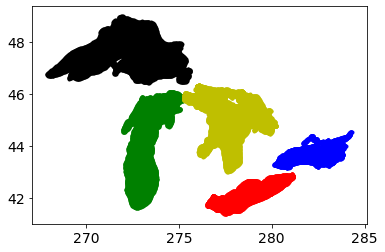

In [11]:
# FVCOM mask
lon = train_dict['LST'][0][1].lon.values
lat = train_dict['LST'][0][1].lat.values
superior = (lat > 46.2) & (lon < 275.9)
plt.plot(lon[superior],lat[superior],'k.')
erie = (lat < 43) & (lon > 275)
plt.plot(lon[erie],lat[erie],'r.')
ontario = (lat > 43) & (lat < 44.55) & (lon > 280)
plt.plot(lon[ontario],lat[ontario],'b.')
michigan = (lat < 46.25) & (lon < 275.25)
plt.plot(lon[michigan],lat[michigan],'g.')
huron = ~((michigan) | (superior) | (erie) | (ontario)) & (lon < 282)
plt.plot(lon[huron],lat[huron],'y.')
plt.show()

var = 'LST'
lake_dict = {}
lake_dict[var] = {'Superior': superior,
             'Huron': huron,
             'Michigan': michigan,
             'Ontario': ontario,
             'Erie': erie,
            }

model_points = {}
model_points[var] = stack((lon,lat)).transpose()

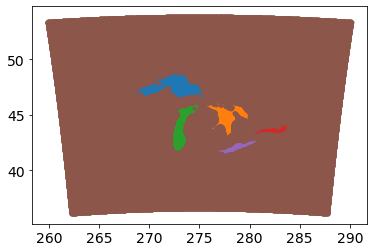

In [12]:
# WRF mask
wrflon = train_dict['T2'][0][1].XLONG.values + 360
wrflat = train_dict['T2'][0][1].XLAT.values

var = 'T2m'
model_points[var] = stack((wrflon.flatten(),wrflat.flatten())).transpose()

lake_dict[var] = {'Superior': superior,
             'Huron': huron,
             'Michigan': michigan,
             'Ontario': ontario,
             'Erie': erie,
            }
for ll,lake in enumerate(lake_dict[var]):
    lakeI = lake_dict[var][lake]
    kdt = KDTree(stack((lon[lakeI],lat[lakeI])).transpose())
    d,k = kdt.query(model_points[var])
    ii = (d < 5/111).squeeze()
    plt.plot(lon[lakeI],lat[lakeI],'k.')
    plt.plot(model_points[var][ii,0],model_points[var][ii,1],'.')
    lake_dict[var][lake] = ii
    if ll == 0:
        all_lakes = ii
    else:
        all_lakes = ii | all_lakes
    
land = ~all_lakes
plt.plot(model_points[var][land,0],model_points[var][land,1],'.')

In [13]:
# construct the training data into right dimensions
model_data = {}
model_data['LST'] = {}
ntime2 = {}
for rdx, run in enumerate(train_dict['LST']):
    tdx = (run[0] >= ts) & (run[0] < te)
    ntime2['LST'] = tdx.sum()
    value_temp = run[1].isel(time=tdx).values.reshape(1,-1)
    if rdx == 0:
        model_data['LST']['train'] = value_temp
    else:
        model_data['LST']['train'] = append(model_data['LST']['train'],value_temp,axis=0)
display(model_data['LST']['train'].shape)
        
# construct the training data into right dimensions
for rdx, run in enumerate(test_dict['LST']):
    tdx = (run[0] >= ts) & (run[0] < te)
    ntime2_ = tdx.sum()
    value_temp = run[1].isel(time=tdx).values.reshape(1,-1)
    if rdx == 0:
        model_data['LST']['test'] = value_temp
    else:
        model_data['LST']['test'] = append(model_data['LST']['test'],value_temp,axis=0)
assert(ntime2['LST'] == ntime2_)

display(model_data['LST']['test'].shape)

(18, 3288908)

(5, 3288908)

In [14]:
# construct the training data into right dimensions
model_data['T2m'] = {} 
for rdx, run in enumerate(train_dict['T2']):
    tdx = (run[0] >= ts) & (run[0] < te)
    ntime2['T2m'] = tdx.sum()
    value_temp = run[1].isel(time=tdx).values.reshape(1,-1)
    if rdx == 0:
        model_data['T2m']['train'] = value_temp
    else:
        model_data['T2m']['train'] = append(model_data['T2m']['train'],value_temp,axis=0)
display(model_data['T2m']['train'].shape)
        
# construct the training data into right dimensions
for rdx, run in enumerate(test_dict['T2']):
    tdx = (run[0] >= ts) & (run[0] < te)
    ntime2_ = tdx.sum()
    value_temp = run[1].isel(time=tdx).values.reshape(1,-1)
    if rdx == 0:
        model_data['T2m']['test'] = value_temp
    else:
        model_data['T2m']['test'] = append(model_data['T2m']['test'],value_temp,axis=0)
assert(ntime2['T2m'] == ntime2_)

display(model_data['T2m']['test'].shape)

(18, 23915892)

(5, 23915892)

### surrogate models

In [15]:
# load the surrogate models
kl_surrogate = {}
with open(LST_surrogate_filename, 'rb') as fp:
    kl_surrogate['LST'] = pickle.load(fp)
    print('Done loading LST surrogate from binary file')
    
with open(T2_surrogate_filename, 'rb') as fpp:
    kl_surrogate['T2m'] = pickle.load(fpp)
    print('Done loading T2 surrogate from binary file')
    
# surrogate input settings
# using hot_enconding or not
hot_encode = True
# setup training and test inputs based on onehotencoding or not
x_vals = {}
if hot_encode:
    x_vals['train'] = variable_matrix_train
    x_vals['test'] = variable_matrix_test
else:
    x_vals['train'] = ptrain
    x_vals['test'] = ptest

Done loading LST surrogate from binary file
Done loading T2 surrogate from binary file


## Decompose the time series

In [16]:
# some variables for surrogate
var_explained = len(variables) #for PCA

# randomization
random_seeds = range(111,999+111,111)

In [17]:
pca_data = {}
for var in model_data:
    trainY = model_data[var]['train']
    testY = model_data[var]['test']
    # Decompose the spatiotemporal series using PCA/KL
    pca_obj = PCA(n_components=var_explained, 
                  random_state=random_seeds[0], 
                  whiten=True)
    pca_obj.fit(trainY)

    print(pca_obj.explained_variance_ratio_)
    print(pca_obj.explained_variance_ratio_.sum())
    print(f'number of eigenmodes is {pca_obj.n_components_}')
    
    pca_data[var] = {}
    # get the outputs from the PCA
    pca_data[var]['klxi_train'] = pca_obj.transform(trainY)
    pca_data[var]['klxi_test']  = pca_obj.transform(testY)
    pca_data[var]['eigenratio'] = pca_obj.explained_variance_ratio_
    pca_data[var]['neig'] = pca_obj.n_components_
    pca_data[var]['eigenvalues'] = pca_obj.explained_variance_
    pca_data[var]['eigenmodes'] = pca_obj.components_
    pca_data[var]['mean_vector'] = pca_obj.mean_

[0.59524146 0.10616204 0.04990378 0.04276877 0.03184092 0.0306296
 0.02111236 0.0180193  0.01771278]
0.9133910082750212
number of eigenmodes is 9
[0.6299013  0.09171014 0.06312568 0.03856222 0.03501988 0.02503296
 0.01906686 0.01674813 0.01424874]
0.9334159
number of eigenmodes is 9


## Spatially varying sensitivities

### kl_dict temporal average

In [18]:
kl_dict = {}
var = 'LST'

# reshape the mean vector and eigenmodes so we can manipulate by dimension
mean_vector_reshape = pca_data[var]['mean_vector'].reshape(ntime2[var],-1)
eigenmodes_reshape = pca_data[var]['eigenmodes'].reshape(pca_data[var]['neig'],ntime2[var],-1)

point_array = {}
point_array[var] = range(0,eigenmodes_reshape.shape[2],1)

# make time-averaged kl_dict with the point array
kl_dict[var] = {'eigenmodes': eigenmodes_reshape[:,:,point_array[var]].mean(axis=1),
           'eigenvalues': pca_data[var]['eigenvalues'],
           'mean_vector': mean_vector_reshape[:,point_array[var]].mean(axis=0), 
          }

In [19]:
var = 'T2m'

# coarsen the grid to make more computationally efficient

# reshape into gridded form and average
mean_vector_reshape2_timeav = pca_data[var]['mean_vector'].reshape(-1,wrflon.shape[0],wrflon.shape[1]).mean(axis=0)
#(ntime2[var],-1)
eigenmodes_reshape2_timeav = pca_data[var]['eigenmodes'].reshape(-1,ntime2[var],wrflon.shape[0],wrflon.shape[1]).mean(axis=1)
#(pca_data[var]['neig'],ntime2[var],-1)

print(eigenmodes_reshape2_timeav.shape)
print(mean_vector_reshape2_timeav.shape)

#coarsen the grid
coarseness = 3
# Suppose the size of pop_density was 198x147 instead of 200x150.
# Start by finding the next highest multiple of 5x5
shape = array(mean_vector_reshape2_timeav.shape, dtype=float)
new_shape = coarseness * ceil(shape / coarseness).astype(int)

for ai,array2d in enumerate([mean_vector_reshape2_timeav, wrflon, wrflat]):

    # Create the zero-padded array and assign it with the old values
    # mean vector
    zp_temp = zeros(new_shape)
    zp_temp[:int(shape[0]), :int(shape[1])] = array2d
    zp_temp[int(shape[0])::,:int(shape[1])] = array2d[-1,:].reshape(1,-1)
    zp_temp[:int(shape[0]),int(shape[1])::] = array2d[:,-1].reshape(-1,1)
    zp_temp[int(shape[0])::,int(shape[1])::] = array2d[-1,-1]

    temp = zp_temp.reshape((new_shape[0] // coarseness, coarseness,
                            new_shape[1] // coarseness, coarseness))
    if ai == 0:
        mean_vector_reshape2_timeav_upscaled = temp.mean(axis=(1,3))
    elif ai == 1:
        wrflon_upscaled = temp.mean(axis=(1,3))
    elif ai == 2:
        wrflat_upscaled = temp.mean(axis=(1,3))
    
print(mean_vector_reshape2_timeav_upscaled.shape)

# eigenmodes
zp_temp = zeros([pca_data[var]['neig'],new_shape[0],new_shape[1]])
zp_temp[:,:int(shape[0]), :int(shape[1])] = eigenmodes_reshape2_timeav
zp_temp[:,int(shape[0])::,:int(shape[1])] = eigenmodes_reshape2_timeav[:,-1,:].reshape(pca_data[var]['neig'],1,-1)
zp_temp[:,:int(shape[0]),int(shape[1])::] = eigenmodes_reshape2_timeav[:,:,-1].reshape(pca_data[var]['neig'],-1,1)
for ei in range(pca_data[var]['neig']):
    zp_temp[ei,int(shape[0])::,int(shape[1])::] = eigenmodes_reshape2_timeav[ei,-1,-1]

temp = zp_temp.reshape((-1,
                        new_shape[0] // coarseness, coarseness,
                        new_shape[1] // coarseness, coarseness))

eigenmodes_reshape2_timeav_upscaled = temp.mean(axis=(2,4))
print(eigenmodes_reshape2_timeav_upscaled.shape)

# kl_dict for coarsened grid
kl_dict[var] = {'eigenmodes': eigenmodes_reshape2_timeav_upscaled.reshape(pca_data[var]['neig'],-1),
           'eigenvalues': pca_data[var]['eigenvalues'],
           'mean_vector': mean_vector_reshape2_timeav_upscaled.flatten(),
          }

# just dummy for the grid coarsening method
point_array[var] = range(0,eigenmodes_reshape.shape[2],1)
#
# use WRF mask to make kl_dict for lake and land..
#kl_dict[var] = {'eigenmodes': eigenmodes_reshape[:,:,point_array[var]].mean(axis=1),
#           'eigenvalues': pca_data[var]['eigenvalues'],
#           'mean_vector': mean_vector_reshape[:,point_array[var]].mean(axis=0), 
#          }

(9, 484, 543)
(484, 543)
(162, 181)
(9, 162, 181)


### GSA for LST and T2m in space

In [20]:
# assign and execute the sensitivity computation in parallel
def add_helper(queue, pn, a1, a2, a3, a4): # the func called in child processes
    sens_sobol, srange = compute_sensitivities(a1, a2, sample_size=a3, kl_dict=a4)
    queue.put([sens_sobol, srange, pn])

q = Queue()
processes = []
proc_num = 0
sample_size = 2**8
for var in ['LST','T2m']:
    for sur in kl_surrogate[var]['NN']:
        p = Process(target=add_helper, args=(q, proc_num, sur, x_vals['train'], sample_size, kl_dict[var]))
        processes.append(p)
        p.start()
        proc_num += 1
        
rets = [None] * proc_num
for p in processes:
    ret = q.get() 
    print(f'proc_num = {ret[-1]}')
    rets[ret[-1]] = ret[0:2] # add in the right order based on proc_number
for p in processes:
    p.join()

Initializing SOBOL
Initializing SOBOL
Sampling SOBOL


Sampling SOBOLInitializing SOBOLInitializing SOBOL
Sampling SOBOL
Initializing SOBOLSampling SOBOL
Initializing SOBOLSampling SOBOL


Initializing SOBOL
Sampling SOBOL
Initializing SOBOLSampling SOBOL
Initializing SOBOL
Initializing SOBOL
Sampling SOBOL

Sampling SOBOLInitializing SOBOL
Sampling SOBOL

Initializing SOBOL
Sampling SOBOLInitializing SOBOLInitializing SOBOLSampling SOBOL

Initializing SOBOLInitializing SOBOL


Sampling SOBOLInitializing SOBOL


Sampling SOBOLSampling SOBOL

Initializing SOBOL
Sampling SOBOL
Sampling SOBOLSampling SOBOL

proc_num = 12
proc_num = 14
proc_num = 17
proc_num = 16
proc_num = 11
proc_num = 13
proc_num = 15
proc_num = 9
proc_num = 10
proc_num = 8
proc_num = 0
proc_num = 3
proc_num = 2
proc_num = 7
proc_num = 1
proc_num = 6
proc_num = 4
proc_num = 5


In [21]:
# collect all uncertainty and sensitivity data
SENSD_spatial = {}
nn = 0
for var in ['LST','T2m']: # loop over variables 
    print(var)
    sens_info = {}
    tvs = {} #'main': [], 'total': []}
    for ss, sur in enumerate(kl_surrogate[var]['NN']):
        sens_sobol, srange = rets[nn]
        if ss == 0:
            gsa_range = srange
        else:
            gsa_range = append(gsa_range,srange,axis=0)

        for sens_label in ['main','total']:
            if ss == 0:
                tvs[sens_label] = sens_sobol[sens_label]
            else:
                tvs[sens_label] += sens_sobol[sens_label]
        nn += 1
        
    for sens_label in ['main','total']:           
        tvs[sens_label] /= len(kl_surrogate[var]['NN'])

    SENSD_spatial[var] = {'gsa_range': gsa_range, 'tvs': tvs}

LST
T2m


## Plotting spatial variation of uncertainty

In [22]:
# compute uncertainty first as can take some time
for var in ['LST','T2m']: # 
    SENSD_spatial[var]['uncertainty'] = (
        quantile(SENSD_spatial[var]['gsa_range'],0.95,axis=0) -
        quantile(SENSD_spatial[var]['gsa_range'],0.05,axis=0)
                  )

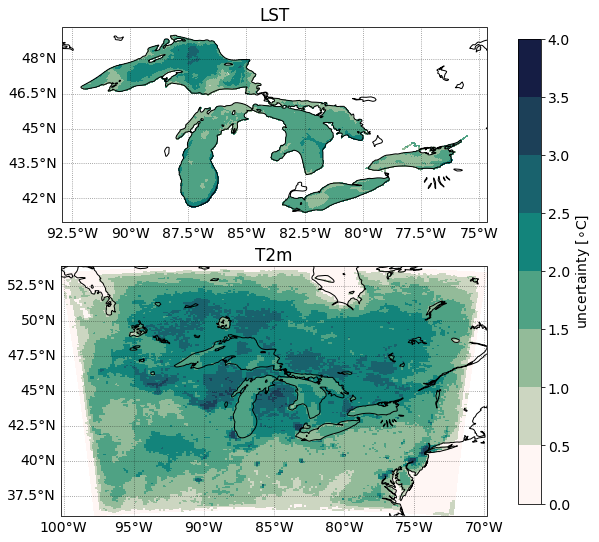

In [60]:
fig, axs = plt.subplots(2, 1, figsize=(11,9),
                       gridspec_kw={'height_ratios': [1, 1.28]},
                       subplot_kw={'projection': PlateCarree()},
                       )

vmin = 0
vmax = 4
cmap_N = 8
cdict = cmocean.tools.get_dict(cmocean.cm.tempo)
cmap_d = colors.LinearSegmentedColormap('tempo_d', segmentdata=cdict, N=cmap_N)
for vv, var in enumerate(['LST','T2m']): # loop over var
    
    ax = axs.flat[vv]

    # Download and add the states and coastlines
    coast = NaturalEarthFeature(
            category='physical',
            name='coastline',
            facecolor='none',
            scale='50m')
    lakes = NaturalEarthFeature(
            category='physical',
            name='lakes',
            facecolor='none',
            scale='50m')
    ax.add_feature(lakes)
    ax.add_feature(coast)
    
    if point_array[var].step == 1:
        if var == 'LST':
            im = ax.tripcolor(
                fvcom_tri,
                SENSD_spatial[var]['uncertainty'],
                vmin=vmin,vmax=vmax,
                transform = PlateCarree(),
                cmap=cmap_d,
            )    
        elif var == 'T2m':
            im = ax.pcolor(
                wrflon_upscaled,
                wrflat_upscaled,
                SENSD_spatial[var]['uncertainty'].reshape(wrflon_upscaled.shape[0],wrflon_upscaled.shape[1]),
                vmin=vmin,vmax=vmax,
                transform = PlateCarree(),
                cmap=cmap_d,
            )
    else:
        im = ax.scatter(
            model_points[var][point_array[var],0]-360,
            model_points[var][point_array[var],1],
            c=uncertainty[var],
            s=2,
            vmin=vmin,vmax=vmax,
            transform = PlateCarree(),
            cmap=cmapp,
        )     
        
    ax.set_title(f'{var}')
    gl = ax.gridlines(color="black", linestyle="dotted", draw_labels=True, alpha=0.5)
    gl.top_labels = None
    gl.right_labels = None
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

cbar = fig.colorbar(im, ax=axs.ravel().tolist(), 
                    shrink=0.95, label='uncertainty [$\circ$C]',
                    #extend='both',
                   )

plt.savefig('../figures/uncertainty_spatial_dist',dpi=600,bbox_inches='tight')
plt.show()

### Plot spatial variation of sensitivities

In [24]:
pname_paper = ['PBL+SFC', 'MP', 'LW+SW Rad', 'z0$_w$', 'LSM', 
               'VM', 'WS', 'Pr$_t$', '$R$']
# only choose top 6
pnames_sel = array(pname_paper)[[0,1,2,3,4,6]]
#pnames_sel = array(pname_paper)[[0,2,4,6]]
print(pnames_sel)

['PBL+SFC' 'MP' 'LW+SW Rad' 'z0$_w$' 'LSM' 'WS']


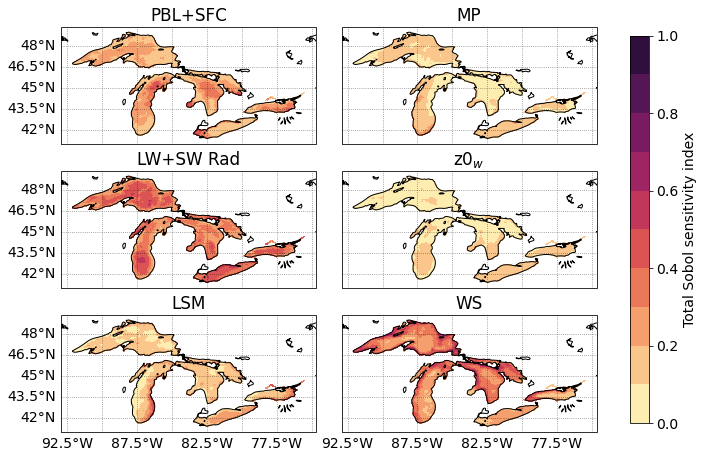

In [59]:
#LST
var = 'LST'
fig, axs = plt.subplots(3, 
                        2, sharey=True, sharex=True, 
                        figsize=(12,7.5), #(14,10),
                       subplot_kw={'projection': PlateCarree()})
vmin=0
vmax=1
cmap_N = 10
cdict = cmocean.tools.get_dict(cmocean.cm.matter)
cmap_d = colors.LinearSegmentedColormap('matter_d', segmentdata=cdict, N=cmap_N)
for adx,pname in enumerate(pnames_sel):

    ax = axs.flat[adx]

    # Download and add the states and coastlines
    coast = NaturalEarthFeature(
            category='physical',
            name='coastline',
            facecolor='none',
            scale='50m')
    lakes = NaturalEarthFeature(
            category='physical',
            name='lakes',
            facecolor='none',
            scale='50m')
    ax.add_feature(lakes)
    ax.add_feature(coast)
    
    pdx = pname_paper.index(pname)
    if point_array[var].step == 1:
        im = ax.tripcolor(
            fvcom_tri,
            SENSD_spatial[var]['tvs']['total'][:,pdx],
            vmin=vmin,vmax=vmax,
            transform = PlateCarree(),
            #norm=colors.LogNorm(vmin=1e-2,vmax=1.0),
            cmap=cmap_d,
        )   
    else:
        im = ax.scatter(model_points[var][point_array[var],0]-360,
             model_points[var][point_array[var],1],
             c=SENSD_spatial[var]['tvs']['total'][:,pdx],
             s=2,        
             transform = PlateCarree(),
             #norm=colors.LogNorm(vmin=1e-2,vmax=1.0),
             cmap=cmap_d,  
            )
    ax.set_title(f'{pname}')
    gl = ax.gridlines(color="black", linestyle="dotted", draw_labels=True, alpha=0.5)
    gl.top_labels = None
    gl.right_labels = None
    if adx < 4: #< 2: #
        gl.bottom_labels = None
    if adx % 2 == 1:
        gl.left_labels = None
        
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

plt.subplots_adjust(wspace=0.1)

cbar = fig.colorbar(im, ax=axs.ravel().tolist(), 
                    shrink=0.95, label='Total Sobol sensitivity index',
                    #extend='both',
                   )
#cbar.set_ticks([0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0])
#cbar.set_ticklabels(['0.01','0.02','0.05','0.1','0.2','0.5','1.0'])
#cbar.set_ticks([0.05,0.1, 0.2, 0.3, 0.4, 0.5])
#cbar.set_ticklabels(['0.05','0.1','0.2','0.3','0.4','0.5','0.6'])

#plt.suptitle('Spatial variation in LST sensitivity')
plt.savefig('../figures/LST_sensitivities_spatial_dist',dpi=600,bbox_inches='tight')
plt.show()

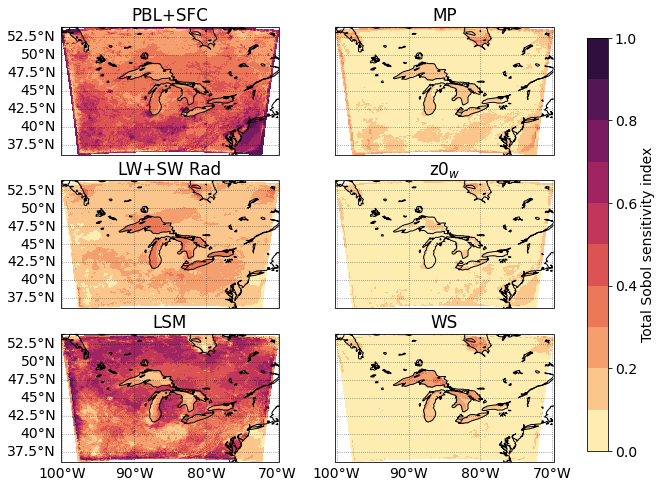

In [58]:
#T2m
var = 'T2m'
fig, axs = plt.subplots(3, 
                        2, sharey=True, sharex=True, 
                        figsize=(12,8), #(14,10),
                       subplot_kw={'projection': PlateCarree()})

vmin=0
vmax=1
cmap_N = 10 
cdict = cmocean.tools.get_dict(cmocean.cm.matter)
cmap_d = colors.LinearSegmentedColormap('matter_d', segmentdata=cdict, N=cmap_N)
for adx,pname in enumerate(pnames_sel):

    ax = axs.flat[adx]

    # Download and add the states and coastlines
    coast = NaturalEarthFeature(
            category='physical',
            name='coastline',
            facecolor='none',
            scale='50m')
    lakes = NaturalEarthFeature(
            category='physical',
            name='lakes',
            facecolor='none',
            scale='50m')
    ax.add_feature(lakes)
    ax.add_feature(coast)
    
    pdx = pname_paper.index(pname)
    if point_array[var].step == 1:
        im = ax.pcolor(
            wrflon_upscaled,
            wrflat_upscaled,
            SENSD_spatial[var]['tvs']['total'][:,pdx].reshape(wrflon_upscaled.shape[0],wrflon_upscaled.shape[1]),
            vmin=vmin,vmax=vmax,
            transform = PlateCarree(),
            #norm=colors.LogNorm(vmin=1e-2,vmax=1.0),
            cmap=cmap_d,
        )   
    else:
        im = ax.scatter(model_points[var][point_array[var],0]-360,
             model_points[var][point_array[var],1],
             c=SENSD_spatial[var]['tvs']['total'][:,pdx],
             s=2,        
             transform = PlateCarree(),
             #norm=colors.LogNorm(vmin=1e-2,vmax=1.0),
             cmap=cmap_d,  
            )
    ax.set_title(f'{pname}')
    gl = ax.gridlines(color="black", linestyle="dotted", draw_labels=True, alpha=0.5)
    gl.top_labels = None
    gl.right_labels = None
    gl.xlocator = FixedLocator([-100,-90,-80,-70])
    if adx < 4:
        gl.bottom_labels = None
        
    if adx % 2 == 1:
        gl.left_labels = None

plt.subplots_adjust(wspace=0.05)

cbar = fig.colorbar(im, ax=axs.ravel().tolist(), 
                    shrink=0.95, label='Total Sobol sensitivity index',
                    #extend='both',
                   )
#cbar.set_ticks([0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0])
#cbar.set_ticklabels(['0.01','0.02','0.05','0.1','0.2','0.5','1.0'])
#cbar.set_ticks([0.05,0.1, 0.2, 0.3, 0.4, 0.5])
#cbar.set_ticklabels(['0.05','0.1','0.2','0.3','0.4','0.5','0.6'])

#plt.suptitle('Spatial variation in LST sensitivity')
plt.savefig('../figures/T2m_sensitivities_spatial_dist',dpi=600,bbox_inches='tight')
plt.show()